### Code

In [1]:
import numpy as np
from PIL import Image
import math
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

class Interpolatable_Image:

    def __init__(self, src='img.png'):
        image = Image.open(src).convert("L")
        self.img = np.array(image)
        self.img_y, self.img_x = self.img.shape
        self.multiply = None


    def __expand(self, multiply=2): #can be improved by custom size
        if(self.multiply!=multiply):
            self.multiply = multiply
        new_img = np.zeros(shape=(self.img_y*self.multiply-1, self.img_x*self.multiply-1))
        for i in range(0, self.img_y):
            for j in range(0, self.img_x):
                new_img[i*self.multiply][j*self.multiply] = self.img[i][j]
        # self.show(new_img)
        return new_img
    

    def poly(xs, ys, show=False):
        if(len(xs)>5):
            print('too big polynom degree')
        ys = np.array(ys).reshape((len(ys), 1))
        xs_poly = np.array([[x**i for i in range(len(xs)-1, -1, -1)] for x in xs])
        # print(xs_poly)
        res_coefs = np.linalg.inv(xs_poly).dot(ys)
        res_coefs = [val for val in res_coefs.reshape((1, len(res_coefs)))[0]]
        # print('result:', res_coefs)
        
        #show
        if(show):
            def polynomial(x, coef):
                y = sum(coef * x**i for i, coef in enumerate(coef[::-1]))
                return y

            freq = 10
            x_values = np.linspace(min(xs), max(xs), freq*len(xs)) #the predicted values
            y_values = polynomial(x_values, res_coefs)

            plt.plot(x_values, y_values, label='Polynomial')
            plt.scatter(xs, ys, color='red', label='Data Points') 
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Polynomial Fit')
            plt.legend()
            plt.grid(True)
            plt.show()

        return res_coefs


    def show(self, spec=[]):
        if(spec.shape != (1,0)):
            Image.fromarray(spec).show()    
        else: Image.fromarray(self.img).show()

    
    def liniar_interpolation(self, scale=2):
        new_img = self.__expand(scale)
        for i in range(0, len(new_img)-self.multiply, self.multiply):
            for j in range(0, len(new_img[0])-self.multiply, self.multiply):
                X1 = j; X2 = j+self.multiply
                Y1 = i; Y2 = i+self.multiply
                for y in range(Y1, Y2+1):
                    for x in range(X1, X2+1):
                        temp = self.img[int(Y1/self.multiply)][int(X1/self.multiply)]*(X2-x)*(Y2-y)+self.img[int(Y1/self.multiply)][int(X2/self.multiply)]*(x-X1)*(Y2-y)+self.img[int(Y2/self.multiply)][int(X1/self.multiply)]*(X2-x)*(y-Y1)+self.img[int(Y2/self.multiply)][int(X2/self.multiply)]*(x-X1)*(y-Y1)
                        res = temp/((X2-X1)*(Y2-Y1))
                        new_img[y][x] = res
        return new_img


    def Transpose(self):
        self.img = self.img.T
        self.img_x, self.img_y = self.img_y, self.img_x

    ## degree should be less 6
    def poly_interpolation(self, scale=2, degree=4):
        if(degree>5):
            print('try degree lower')
            return
        new_img = self.__expand(scale)


        def polynomial(x, coef):
            y = sum(coef * x**i for i, coef in enumerate(coef[::-1]))
            return y


        def fill_horizonal_every_skip(img, step):
            if(step!=1):
                step = scale
            for i in range(0, len(img)-step, step):
                xs = [k for k in range(0, self.img_x*scale, scale)]
                ys = self.img[int(np.floor(i/scale))]


                for j in range(0, len(xs)-degree, degree):
                    xs_segment = xs[j:j+degree]
                    ys_segment = ys[j:j+degree]
                    coefs = Interpolatable_Image.poly(xs_segment, ys_segment, show=False)

                    x_values = np.linspace(j*scale, j*scale+scale*degree-1, scale*degree)
                    y_values = polynomial(x_values, coefs)
                    img[i][j*scale:j*scale+scale*degree] = y_values
            return img
        
        new_img = fill_horizonal_every_skip(new_img, 2)
        self.Transpose()
        new_img = fill_horizonal_every_skip(new_img.T, 1).T
        return new_img


    def furie_interpolation(self):
        new_img = self.img.copy()
        nx,ny = 200,200
        x, y = [i for i in range(nx)], [i for i in range(ny)]
        put_x = 3; put_y = 3
        X = [0]*nx
        Y = [0]*ny
        for i in range(nx):
            X[i] = i + (i-1)*put_x
            # X[i] = (i-1)*put_x
            for j in range(ny):
                Y[i] = j+(j-1)*put_y
                # Y[i] = (j-1)*put_y
                new_img[i][j] = math.sin(x[i]/nx*math.pi)*math.cos(2*y[j]/ny*math.pi)+1
        Y, X = np.meshgrid(Y, X)
        nx_new = nx+(nx-1)*put_x
        ny_new = ny+(ny-1)*put_y
        x_new = [i for i in range(nx_new)]
        y_new = [i for i in range(ny_new)]
        y_new, x_new = np.meshgrid(y_new, x_new)
        my_image_new = zoom(new_img, (nx_new/new_img.shape[0], ny_new/new_img.shape[1]))        
        return my_image_new
    

    def mls(xs_set, ys_set, show=False): # (x1, x2, x3), (y1, y2, y3)
        xs_2 = sum(x**2 for x in xs_set)
        # print('\nsum xs_2', xs_2)
        xs = sum(x for x in xs_set)
        # print('sum xs', xs)
        xy = np.array(xs_set).reshape((1, len(xs_set))).dot(np.array(ys_set).reshape((len(ys_set), 1)))[0][0]
        # print('sum xy', xy)
        ys = sum(y for y in ys_set)
        # print('sum ys', ys)
        A = np.array([[xs_2, xs], [xs, 3]])
        M = np.array([[xy, ys]]).T
        coefs = np.linalg.inv(A).dot(M)
        coefs = [val for val in coefs.reshape((1, len(coefs)))[0]]
        # print('result:', coefs)

        # show
        if(show):
            # line
            def line(x, a, b):
                y = x*a + b
                return y

            x_values = np.linspace(min(xs_set), max(xs_set), 2*len(xs_set))
            y_values = line(x_values, coefs[0], coefs[1])

            plt.plot(x_values, y_values, label='MLS')
            plt.scatter(xs_set, ys_set, color='red', label='Data Points') 
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('MLS Fit')
            plt.legend()
            plt.grid(True)
            plt.show()

        return coefs


    def mls_interpolation(self, scale=2):
        new_img = self.__expand(scale)

        def line(x, a, b):
            y = x*a + b
            return y

        def fill_horizonal_every_skip(img, step):
            if(step!=1):
                step=scale
            for i in range(0, len(img)-step, step):
                mask = img[i]
                xs = [k for k in range(0, self.img_x*scale, scale)]
                ys = self.img[int(np.floor(i/scale))]

                degree = 3
                for j in range(0, len(xs)-degree, degree):
                    xs_segment = xs[j:j+degree]
                    ys_segment = ys[j:j+degree]
                    coefs = Interpolatable_Image.mls(xs_segment, ys_segment, show=False)

                    x_values = np.linspace(j*scale, j*scale+scale*degree-1, scale*degree)
                    y_values = line(x_values, coefs[0], coefs[1])
                    img[i][j*scale:j*scale+scale*degree] = y_values
                img[i] = [img[i][j] if mask[j] != 0 else mask[j] for j in range(len(img[i]))]
            return img
        
        new_img = fill_horizonal_every_skip(new_img, 2)
        self.Transpose()
        new_img = fill_horizonal_every_skip(new_img.T, 1).T
        return new_img

# Interpolations 

In [2]:
img_src = 'img.png'
inter = Interpolatable_Image(img_src)

## Liniar interpolation
### 2d example:

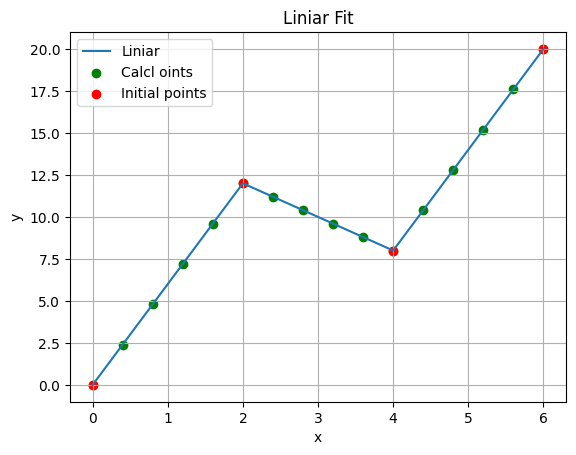

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def lin(xs, ys, scale, show=True):
    new_xs = np.array([xs[0]])
    new_ys = np.array([ys[0]])
    # print('xs:', xs)
    # print('ys:', ys)
    for i in range(1,xs.size):
        ins = np.linspace(xs[i-1]+(xs[i]-xs[i-1])/scale, xs[i], scale)
        new_xs = np.append(new_xs, ins)
    for i in range(1, ys.size):
        ins = np.linspace(ys[i-1]+(ys[i]-ys[i-1])/scale, ys[i], scale)
        new_ys = np.append(new_ys, ins)
    # print('new_xs:', new_xs)
    # print('new_ys:', new_ys)

    #show
    if(show):
        plt.plot(new_xs, new_ys, label='Liniar')
        plt.scatter(new_xs, new_ys, color='green', label='Calcl oints') 
        plt.scatter(xs, ys, color='red', label='Initial points')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Liniar Fit')
        plt.legend()
        plt.grid(True)
        plt.show()


x_data = np.array([0, 2, 4, 6])
y_data = np.array([0, 12, 8, 20])

lin(x_data,y_data, 5)

### Image interpolation:

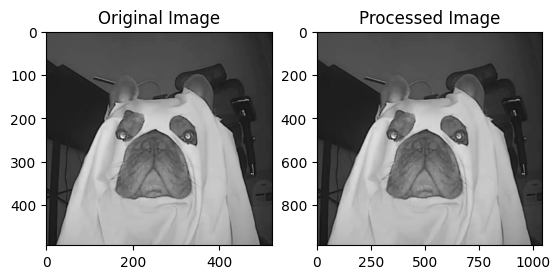

In [4]:
lin_int = inter.liniar_interpolation(scale=2)

fig, axes = plt.subplots(1, 2)

# Display the original image on the first subplot
axes[0].imshow(Image.open(img_src).convert("L"), cmap='gray')
axes[0].set_title('Original Image')

# Display the processed image on the second subplot
axes[1].imshow(lin_int, cmap='gray')
axes[1].set_title('Processed Image')

plt.show()

## Polynomial interpolation
### 2d example:

ys: [[ 0]
 [ 4]
 [ 8]
 [20]]
xs_poly: [[  0   0   0   1]
 [  8   4   2   1]
 [ 64  16   4   1]
 [216  36   6   1]]
result: [0.16666666666666674, -1.0, 3.333333333333334, 0.0]


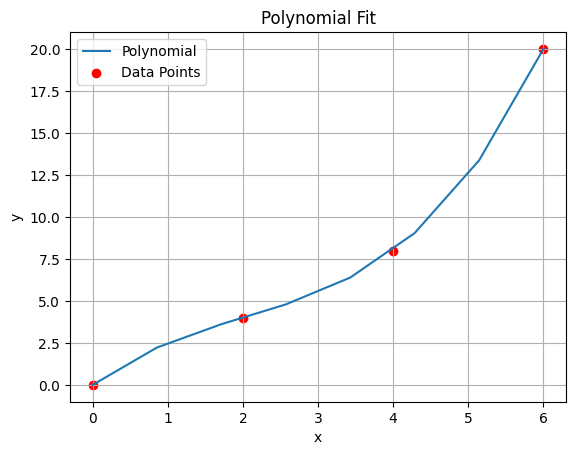

should be: [0.5 0.2 0.4]


In [5]:
# def poly_for_3(xs, ys):
#     ys = np.array(ys).reshape((3,1))
#     print('ys:', ys)
#     xs_poly = np.array([[x**2, x, 1] for x in xs])
#     print('xs_poly:', xs_poly)

#     print('result:', np.linalg.inv(xs_poly).dot(ys))

def poly(xs, ys, show=True):
    ys = np.array(ys).reshape((len(ys), 1))
    print('ys:', ys)
    xs_poly = np.array([[x**i for i in range(len(xs)-1, -1, -1)] for x in xs])
    print('xs_poly:', xs_poly)
    res_coefs = np.linalg.inv(xs_poly).dot(ys)
    res_coefs = [val for val in res_coefs.reshape((1, len(res_coefs)))[0]]
    print('result:', res_coefs)

    #show
    if(show):
        def polynomial(x, coef):
            y = sum(coef * x**i for i, coef in enumerate(coef[::-1]))
            return y

        x_values = np.linspace(min(xs), max(xs), 2*len(xs))
        y_values = polynomial(x_values, res_coefs)

        plt.plot(x_values, y_values, label='Polynomial')
        plt.scatter(xs, ys, color='red', label='Data Points') 
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Polynomial Fit')
        plt.legend()
        plt.grid(True)
        plt.show()


x_data = [0, 2, 4, 6]
y_data = [0, 4, 8, 20]


# poly_for_3(x_data, y_data)
poly(x_data,y_data)
print('should be:', np.polyfit(x_data, y_data, 2))

### Image interpolation:

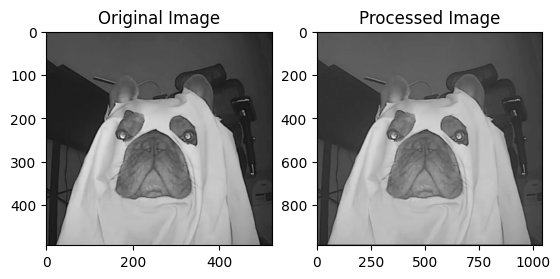

In [6]:
poly = inter.poly_interpolation(scale=2, degree=2)

fig, axes = plt.subplots(1, 2)

# Display the original image on the first subplot
axes[0].imshow(Image.open(img_src).convert("L"), cmap='gray')
axes[0].set_title('Original Image')

# Display the processed image on the second subplot
axes[1].imshow(poly, cmap='gray')
axes[1].set_title('Processed Image')

plt.show()

## Furie interpolation:
### !2d example: (!!!not done)

### Image interpolation:

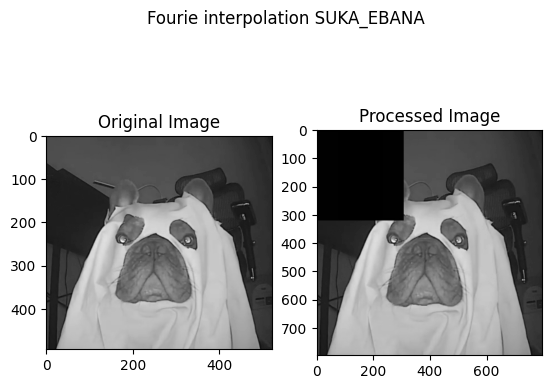

In [18]:
fur = inter.furie_interpolation()

fig, axes = plt.subplots(1, 2)

# Display the original image on the first subplot
axes[0].imshow(Image.open(img_src).convert("L"), cmap='gray')
axes[0].set_title('Original Image')

# Display the processed image on the second subplot
axes[1].imshow(fur, cmap='gray')
axes[1].set_title('Processed Image')

plt.show()

## Method of least squers (liniar regression)
### 2d representation:


sum xs_2 13
sum xs 5
sum xy 14
sum ys 6
result: [0.857142857142857, 0.5714285714285711]


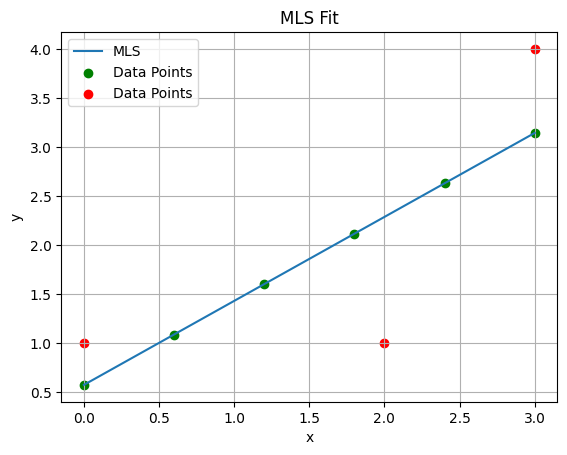

In [8]:
def mls(xs_set, ys_set, show=False): # (x1, x2, x3), (y1, y2, y3)
    xs_2 = sum(x**2 for x in xs_set);       print('\nsum xs_2', xs_2)
    xs = sum(x for x in xs_set);            print('sum xs', xs)
    xy = np.array(xs_set).reshape((1, len(xs_set))).dot(np.array(ys_set).reshape((len(ys_set), 1)))[0][0]
    print('sum xy', xy)
    ys = sum(y for y in ys_set);            print('sum ys', ys)
    A = np.array([[xs_2, xs], [xs, 3]])
    M = np.array([[xy, ys]]).T
    coefs = np.linalg.inv(A).dot(M)
    coefs = [val for val in coefs.reshape((1, len(coefs)))[0]]
    print('result:', coefs)

    # show
    if(show):
        # line
        def line(x, a, b):
            y = x*a + b
            return y

        x_values = np.linspace(min(xs_set), max(xs_set), 2*len(xs_set))
        y_values = line(x_values, coefs[0], coefs[1])

        plt.plot(x_values, y_values, label='MLS')
        plt.scatter(x_values, y_values, color='green', label='Data Points') 
        plt.scatter(xs_set, ys_set, color='red', label='Data Points') 
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('MLS Fit')
        plt.legend()
        plt.grid(True)
        plt.show()

mls([0,2,3], [1,1,4], show=True)

### Image interpolation:

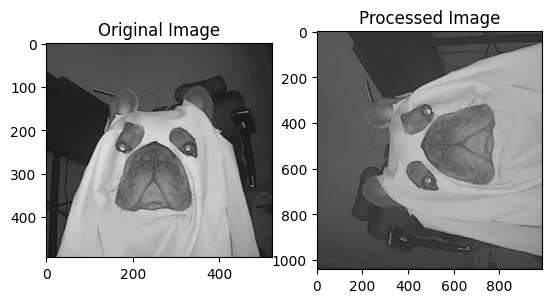

In [9]:
mls_int = inter.mls_interpolation(scale=2)

fig, axes = plt.subplots(1, 2)

# Display the original image on the first subplot
axes[0].imshow(Image.open(img_src).convert("L"), cmap='gray')
axes[0].set_title('Original Image')

# Display the processed image on the second subplot
axes[1].imshow(mls_int, cmap='gray')
axes[1].set_title('Processed Image')

plt.show()